In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error

In [9]:
def load_and_clean_data():
    df_gold = pd.read_csv('Gold Price (2013-2023).csv')
    df_gold['Date'] = pd.to_datetime(df_gold['Date'])
    for col in ['Price', 'Open', 'High', 'Low']:
        df_gold[col] = df_gold[col].astype(str).str.replace(',', '').astype(float)
    df_gold = df_gold.sort_values('Date').set_index('Date')

    df_market = pd.read_csv('final_data.csv')
    df_market['Date'] = pd.to_datetime(df_market['Date'], dayfirst=True)
    for col in ['USO', 'SLV', 'S&P500', 'EUR/USD']:
        if df_market[col].dtype == 'object':
            df_market[col] = df_market[col].astype(str).str.replace(',', '').astype(float)
    df_market = df_market.sort_values('Date').set_index('Date')

    df_fed = pd.read_csv('FEDFUNDS.csv')
    df_fed['Date'] = pd.to_datetime(df_fed['observation_date'])
    df_fed = df_fed.set_index('Date')[['FEDFUNDS']]

    df_cpi = pd.read_csv('CORESTICKM159SFRBATL.csv')
    df_cpi['Date'] = pd.to_datetime(df_cpi['observation_date'])
    df_cpi = df_cpi.set_index('Date')[['CORESTICKM159SFRBATL']]
    
    return df_gold, df_market, df_fed, df_cpi

df_gold, df_market, df_fed, df_cpi = load_and_clean_data()

In [10]:
full_idx = pd.date_range(start=df_gold.index.min(), end=df_gold.index.max(), freq='D')
df_fed_daily = df_fed.reindex(full_idx, method='ffill')
df_cpi_daily = df_cpi.reindex(full_idx, method='ffill')

df = df_gold.join([df_market, df_fed_daily, df_cpi_daily], how='inner')

df['Real_Rate'] = df['FEDFUNDS'] - df['CORESTICKM159SFRBATL']
target_col = 'Price'
features_to_log = ['Price', 'S&P500', 'SLV', 'USO', 'EUR/USD']

for col in features_to_log:
    df[f'{col}_LogRet'] = np.log(df[col] / df[col].shift(1))

df = df.dropna()

feature_cols = [
    'Price',        
    'S&P500_LogRet',  
    'SLV_LogRet',     
    'USO_LogRet',
    'EUR/USD',     
    'Real_Rate'   
]
data = df[feature_cols].values
price_data = df['Price'].values
df


,Price,Open,High,Low,Vol.,Change %,USO,SLV,S&P500,EUR/USD,FEDFUNDS,CORESTICKM159SFRBATL,Real_Rate,Price_LogRet,S&P500_LogRet,SLV_LogRet,USO_LogRet,EUR/USD_LogRet
2013-01-03,1675.6,1688.0,1689.3,1664.3,0.19K,-0.85%,269.92,29.18,1459.40,1.3046,0.14,2.065935,-1.925935,-0.008498,-0.002054,-0.025044,-0.002368,-0.010522
2013-01-04,1649.9,1664.4,1664.4,1630.0,0.31K,-1.53%,271.04,29.24,1466.50,1.3067,0.14,2.065935,-1.925935,-0.015457,0.004853,0.002054,0.004141,0.001608
2013-01-07,1647.2,1657.3,1663.8,1645.3,0.09K,-0.16%,271.36,29.18,1461.90,1.3115,0.14,2.065935,-1.925935,-0.001638,-0.003142,-0.002054,0.001180,0.003667
2013-01-08,1663.2,1651.5,1662.6,1648.8,0.13K,0.97%,271.68,29.38,1457.20,1.3080,0.14,2.065935,-1.925935,0.009667,-0.003220,0.006831,0.001179,-0.002672
2013-01-09,1656.5,1660.7,1664.2,1652.3,0.16K,-0.40%,271.04,29.35,1461.00,1.3063,0.14,2.065935,-1.925935,-0.004037,0.002604,-0.001022,-0.002358,-0.001301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,1804.2,1801.0,1812.2,1798.9,105.46K,0.50%,69.32,21.85,3844.82,1.0614,4.10,6.545514,-2.445514,0.004945,0.005851,0.007350,0.023647,0.001980
2022-12-27,1823.1,1808.2,1841.9,1808.0,159.62K,0.74%,69.53,22.11,3829.25,1.0638,4.10,6.545514,-2.445514,0.010421,-0.004058,0.011829,0.003025,0.002259
2022-12-28,1815.8,1822.4,1822.8,1804.2,118.08K,-0.40%,68.58,21.60,3783.22,1.0608,4.10,6.545514,-2.445514,-0.004012,-0.012093,-0.023337,-0.013757,-0.002824
2022-12-29,1826.0,1812.3,1827.3,1811.2,105.99K,0.56%,68.53,21.97,3849.28,1.0661,4.10,6.545514,-2.445514,0.005602,0.017311,0.016985,-0.000729,0.004984


In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :] 
        X.append(a)
        Y.append(dataset[i + time_step, 0]) 
    return np.array(X), np.array(Y)

time_step = 60
X, y = create_dataset(data_scaled, time_step)

train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [12]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1)) 

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
   X_train, 
   y_train, 
   epochs=150, 
   batch_size=32, 
   validation_split=0.1, 
   verbose=1
)

Epoch 1/150


d:\Project 1\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0175 - val_loss: 0.0053
Epoch 2/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 3/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 4/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 5/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 6/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 7/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 10/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 11/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 12/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

In [13]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

def inverse_transform_prediction(pred, scaler):
    dummy = np.zeros((len(pred), scaler.n_features_in_))
    dummy[:, 0] = pred.flatten() 
    return scaler.inverse_transform(dummy)[:, 0]

y_train_inv = inverse_transform_prediction(train_predict, scaler)
y_test_inv = inverse_transform_prediction(test_predict, scaler)

predicted_prices_test = y_test_inv
predicted_prices_train = y_train_inv

N_test = len(y_test_inv)
N_train = len(y_train_inv)

train_size_X = len(X_train) 
test_start_idx = train_size_X + time_step 

actual_prices_test = price_data[test_start_idx:test_start_idx + N_test]
test_indices = df.index[test_start_idx:test_start_idx + N_test]

train_start_idx = time_step 
actual_prices_train = price_data[train_start_idx : train_start_idx + N_train]
train_indices = df.index[train_start_idx : train_start_idx + N_train]

MAPE = mean_absolute_percentage_error(actual_prices_test, predicted_prices_test) 
Accuracy = 1 - MAPE

print("Test Accuracy:", Accuracy)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test Accuracy: 0.9878520715930509


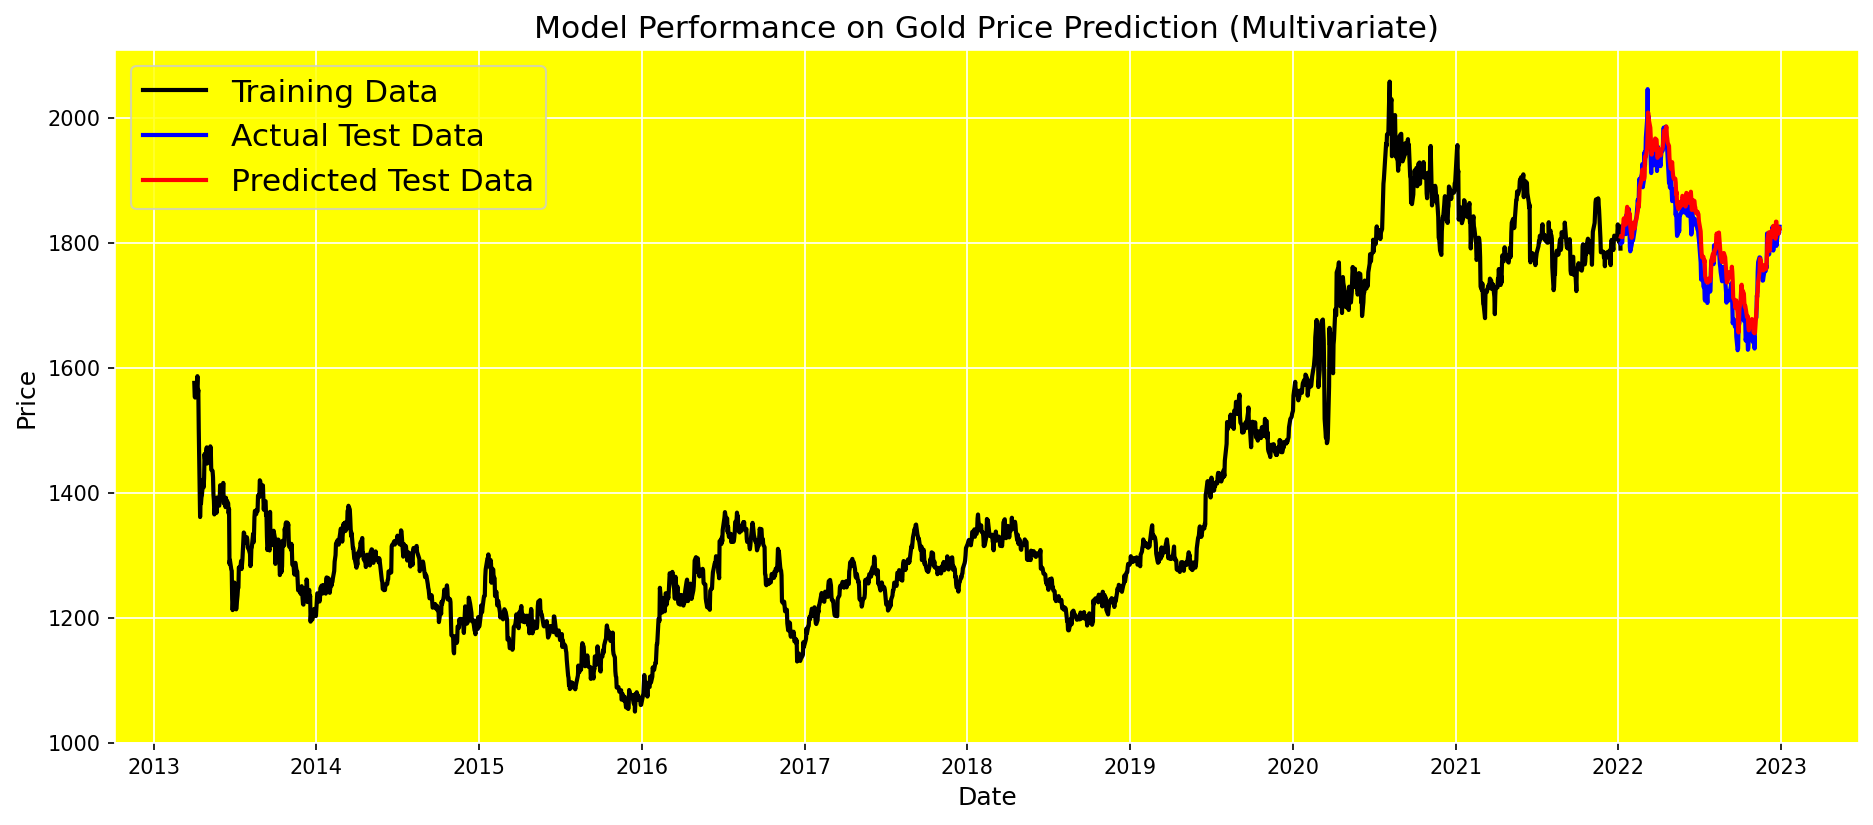

In [14]:
N_train = len(y_train_inv)
N_test = len(y_test_inv)


train_size_X = len(X_train) 
time_step = X_train.shape[1] 

train_start_idx = time_step 
test_start_idx = train_start_idx + N_train

train_dates = df.index[train_start_idx : train_start_idx + N_train]
test_dates = df.index[test_start_idx : test_start_idx + N_test]

actual_prices_train = price_data[train_start_idx : train_start_idx + N_train]
actual_prices_test = price_data[test_start_idx : test_start_idx + N_test]

predicted_prices_test = y_test_inv
predicted_prices_train = y_train_inv


plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes', edgecolor='white')

plt.plot(train_dates, actual_prices_train, color='black', lw=2, label='Training Data')
plt.plot(test_dates, actual_prices_test, color='blue', lw=2, label='Actual Test Data')
plt.plot(test_dates, predicted_prices_test, color='red', lw=2, label='Predicted Test Data')


plt.title('Model Performance on Gold Price Prediction (Multivariate)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white') 

plt.show()